# Laptop price prediction

The goal of this project is to find insights about features and choose the best machine learning regression algorithm to predict prices of laptops better.

Source: [kaggle.com/datasets/muhammetvarl/laptop-price](https://www.kaggle.com/datasets/muhammetvarl/laptop-price)

## Import packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from visualization import *
from evaluation import *

import time
start_time = time.time()

## Load dataset

In [2]:
df = pd.read_csv('data/laptop_price.csv', encoding='latin-1')

In [3]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [4]:
df.shape

(1303, 13)

In [5]:
df.dtypes

laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object

Checking duplicated rows:

In [6]:
len(df.loc[df.duplicated()])

0

Checking whitespaces and missing values:

In [7]:
for col in df.select_dtypes(include='object').columns.tolist():

        if df.loc[df[col].apply(lambda x: x.isspace())].empty == False:
                print(f'{col} has {len(df.loc[df[col].apply(lambda x: x.isspace())])} rows with only space characters. It will be replaced by NaN.')
                df.loc[df[col].apply(lambda x: x.isspace()), col] = np.nan
                df[col] = df[col].astype(float)

In [8]:
df.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

## Exploratory Data Analysis

Before feature engineering to get a basic overview:

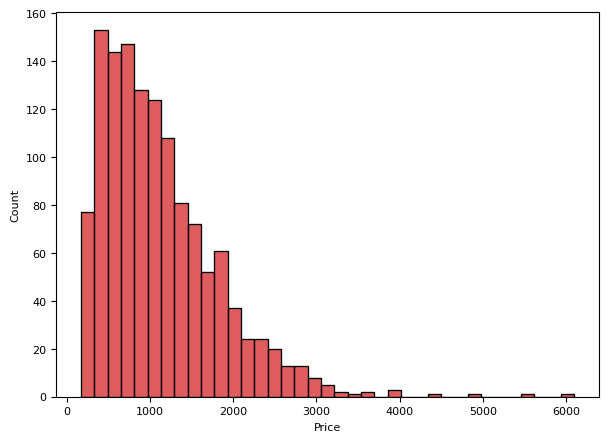

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(df['Price_euros'], color='tab:red')
axes.set_xlabel('Price', fontsize=8)
axes.set_ylabel('Count', fontsize=8)
axes.tick_params(axis='both', which='both', labelsize=8)
plt.show()

* The target variable has a right-skewed distribution, it could be solved with a log-transformation.

In [10]:
df['Price_euros'] = np.log(df['Price_euros'])

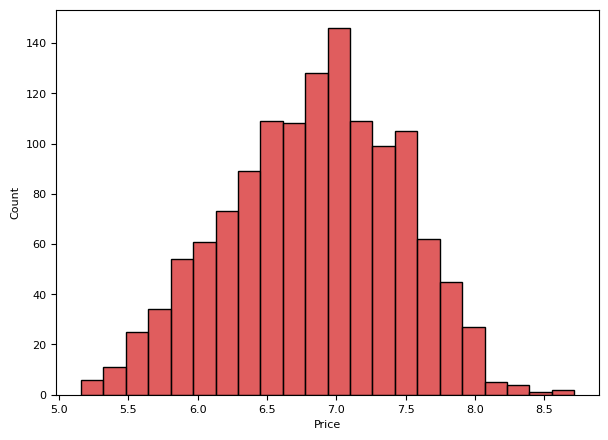

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(df['Price_euros'], color='tab:red')
axes.set_xlabel('Price', fontsize=8)
axes.set_ylabel('Count', fontsize=8)
axes.tick_params(axis='both', which='both', labelsize=8)
plt.show()

Plot some categorical features:

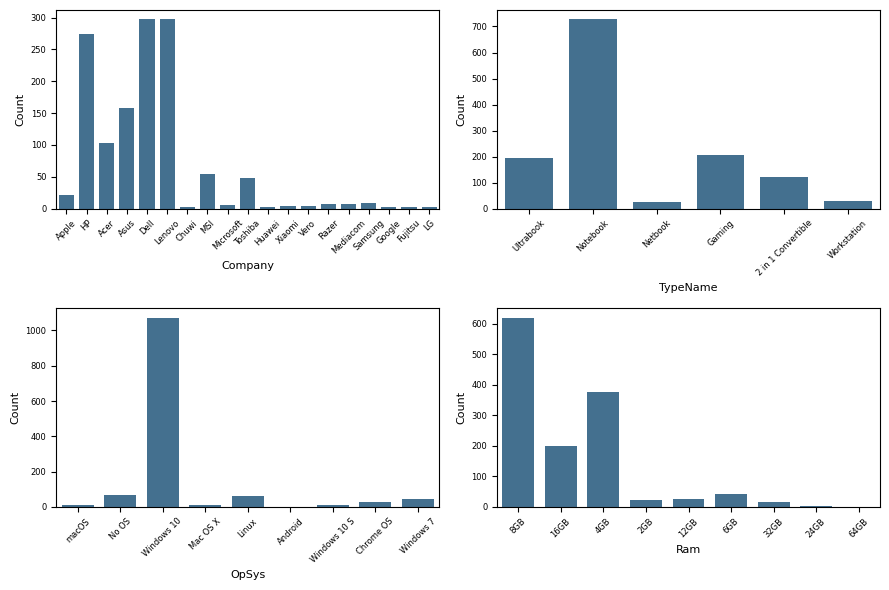

In [12]:
plot_categories(df, ['Company', 'TypeName', 'OpSys', 'Ram'])

* The most popular brands are HP, Dell and Lenovo, while the most popular types are Ultrabook, Notebook and Gaming.
* More than 86% of laptops have a Windows operating system.
* Most of the laptops have 4, 8 or 16GB ram.

## Feature engineering

In [13]:
df.drop('laptop_ID', axis=1, inplace=True)
df.rename(columns={'Price_euros': 'Price'}, inplace=True)

Create **PixelsPerInch** feature using width and height resolution from ScreenResolution and Inches:

In [14]:
df['WidthResolution'] = df['ScreenResolution'].apply(lambda x: int(x.split()[-1].split('x')[0]))
df['HeightResolution'] = df['ScreenResolution'].apply(lambda x: int(x.split()[-1].split('x')[1]))
df['PixelsPerInch'] = round(np.sqrt(df['WidthResolution']**2+df['HeightResolution']**2)/df['Inches'],2)

Create binary features from screen tpyes of ScreenResolution:

In [15]:
df['IPSPanel_Flag'] = np.where(df['ScreenResolution'].apply(lambda x: x.find('IPS Panel')) != -1, 1, 0)
df['RetinaDisplay_Flag'] = np.where(df['ScreenResolution'].apply(lambda x: x.find('Retina Display')) != -1, 1, 0)
df['TouchScreen_Flag'] = np.where(df['ScreenResolution'].apply(lambda x: x.find('Touchscreen')) != -1, 1, 0)

df['FullHD_Flag'] = np.where(df['ScreenResolution'].apply(lambda x: x.find('Full HD')) != -1, 1, 0)
df['QuadHD_Flag'] = np.where(df['ScreenResolution'].apply(lambda x: x.find('Quad HD')) != -1, 1, 0)
df['UltraHD_Flag'] = np.where(df['ScreenResolution'].apply(lambda x: x.find('Ultra HD')) != -1, 1, 0)

In [16]:
df.drop(['ScreenResolution', 'Inches', 'WidthResolution', 'HeightResolution'], axis=1, inplace=True)

Convert Cpu feature into float:

In [17]:
df['CPUGhz'] = df['Cpu'].apply(lambda x: float(x.split()[-1].split('GHz')[0]))

Create **CPUCategory** feature, contains information about the brand of CPU:

In [18]:
df['CPUCategory'] = df['Cpu'].apply(lambda x: x.split()[0])
df.groupby('CPUCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
CPUCategory,,
AMD,62,6.215013
Samsung,1,6.490724
Intel,1240,6.870662


Due to the number of Samsung CPUs in the dataset, this observation will be removed:

In [19]:
df = df.loc[df['CPUCategory'] != 'Samsung'].copy()

Convert Intel category to the subtype of Intel CPUs and AMD category to "Not_Intel":

In [20]:
df['CPUCategory'] = np.where(df['Cpu'].apply(lambda x: x.split()[0]) == 'Intel', (df['Cpu'].apply(lambda x: 'Intel_'+x.split()[1])), 'Not_Intel')
df.groupby('CPUCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
CPUCategory,,
Intel_Atom,13,5.671953
Intel_Celeron,88,5.738093
Intel_Pentium,30,6.044483
Not_Intel,62,6.215013
Intel_Core,1105,6.992844
Intel_Xeon,4,8.126394


Merge and use only signicant groups from Intel as "Intel_Core" and "Other_Intel":

In [21]:
df['CPUCategory'] = np.where(df['CPUCategory'].isin(['Intel_Atom', 'Intel_Celeron', 'Intel_Pentium', 'Intel_Xeon']), 'Other_Intel', df['CPUCategory'])
df.groupby('CPUCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
CPUCategory,,
Other_Intel,135,5.870575
Not_Intel,62,6.215013
Intel_Core,1105,6.992844


Use the subtype of "Intel_Core" categories:

In [22]:
df['CPUCategory'] = np.where(df['CPUCategory'] == 'Intel_Core', df['Cpu'].apply(lambda x: 'Intel_Core_'+x.split(' ')[2]), df['CPUCategory'])
df.groupby('CPUCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
CPUCategory,,
Other_Intel,135,5.870575
Not_Intel,62,6.215013
Intel_Core_i3,136,6.264279
Intel_Core_i5,423,6.857348
Intel_Core_M,19,7.097549
Intel_Core_i7,527,7.285843


Keep relevant groups of them as "Intel_Core_i5" and "Intel_Core_i7":

In [23]:
df['CPUCategory'] = np.where(df['CPUCategory'].isin(['Intel_Core_M', 'Intel_Core_i3']), 'Other_Intel', df['CPUCategory'])
df.groupby('CPUCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
CPUCategory,,
Other_Intel,290,6.135597
Not_Intel,62,6.215013
Intel_Core_i5,423,6.857348
Intel_Core_i7,527,7.285843


In [24]:
df.drop(['Cpu'], axis=1, inplace=True)

Convert Ram feature into float:

In [25]:
df['RamGB'] = df['Ram'].apply(lambda x: int(x.split('GB')[0]))
df.drop(['Ram'], axis=1, inplace=True)

Take information from memory feature about SSD, HDD, Flash Storage and Hybrid:

In [26]:
def get_memory_gb(string, type):

    ssd = 0
    hdd = 0
    flash_storage = 0
    hybrid = 0

    string_list = string.split(' ')

    for i, e in enumerate(string_list):

        if e.find('TB') != -1:
            string_list[i] = str(int(float(e.split('TB')[0]))*1000)+str('GB')

        if e == 'SSD':
            ssd += int(string_list[i-1].split('GB')[0])
        
        elif e == 'HDD':
            hdd += int(string_list[i-1].split('GB')[0])

        elif e == 'Flash':
            flash_storage += int(string_list[i-1].split('GB')[0])

        elif e == 'Hybrid':
            hybrid += int(string_list[i-1].split('GB')[0])

    if type == 'ssd':
        return(ssd)
    
    elif type == 'hdd':
        return(hdd)
    
    elif type == 'flash_storage':
        return(flash_storage)
    
    elif type == 'hybrid':
        return(hybrid)

In [27]:
df['MemorySSDGB'] = df['Memory'].apply(lambda x: get_memory_gb(x, 'ssd'))
df['MemoryHDDGB'] = df['Memory'].apply(lambda x: get_memory_gb(x, 'hdd'))
df['MemoryFlashStorageGB'] = df['Memory'].apply(lambda x: get_memory_gb(x, 'flash_storage'))
df['MemoryHybridGB'] = df['Memory'].apply(lambda x: get_memory_gb(x, 'hybrid'))

In [28]:
df.drop(['Memory'], axis=1, inplace=True)

Create **GPUCategory** feature, contains information about the brand of GPU:

In [29]:
df['GPUCategory'] = df['Gpu'].apply(lambda x: x.split()[0])
df.groupby('GPUCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
GPUCategory,,
AMD,180,6.537328
Intel,722,6.727790
Nvidia,400,7.176920


In [30]:
df.drop(['Gpu'], axis=1, inplace=True)

Merge similar operating system categories:

In [31]:
df['OpSysCategory'] = df['OpSys'].copy()
df['OpSysCategory'].replace(['Android', 'Chrome OS', 'No OS', 'Linux'], 'Other', inplace=True)
df['OpSysCategory'].replace(['Windows 10 S', 'Windows 10', 'Windows 7'], 'Windows', inplace=True)
df['OpSysCategory'].replace(['Mac OS X', 'macOS'], 'Mac', inplace=True)

df.groupby('OpSysCategory').agg(count = ('Product', 'count'), avg_price = ('Price', 'mean')).sort_values(by='avg_price')

,count,avg_price
OpSysCategory,,
Other,156,6.265046
Windows,1125,6.910510
Mac,21,7.299084


In [32]:
df.drop(['OpSys'], axis=1, inplace=True)

Convert weight of laptop feature into float:

In [33]:
df['WeightKG'] = df['Weight'].apply(lambda x: float(x.split('kg')[0]))

In [34]:
df.drop(['Weight'], axis=1, inplace=True)

### Create dummy features

In [35]:
dummy = OneHotEncoder(drop='first')

numerical_features = df.select_dtypes(exclude='object').columns.tolist()
numerical_features.remove('Price')
categorical_features = ['CPUCategory', 'GPUCategory', 'OpSysCategory']

In [36]:
pd.DataFrame(dummy.fit_transform(df[categorical_features]).toarray(),
             columns=dummy.get_feature_names_out(), index=df.index).shape[1]

7

In [37]:
df = pd.concat([df, pd.DataFrame(dummy.fit_transform(df[categorical_features]).toarray(),
             columns=dummy.get_feature_names_out(), index=df.index).astype(int)], axis=1).copy()

dummy_features = df.columns.tolist()[-7:]

## Exploratory Data Analysis 2.0

After feature engineering there is another section of finding insights before model fitting.

Plot categorical features:

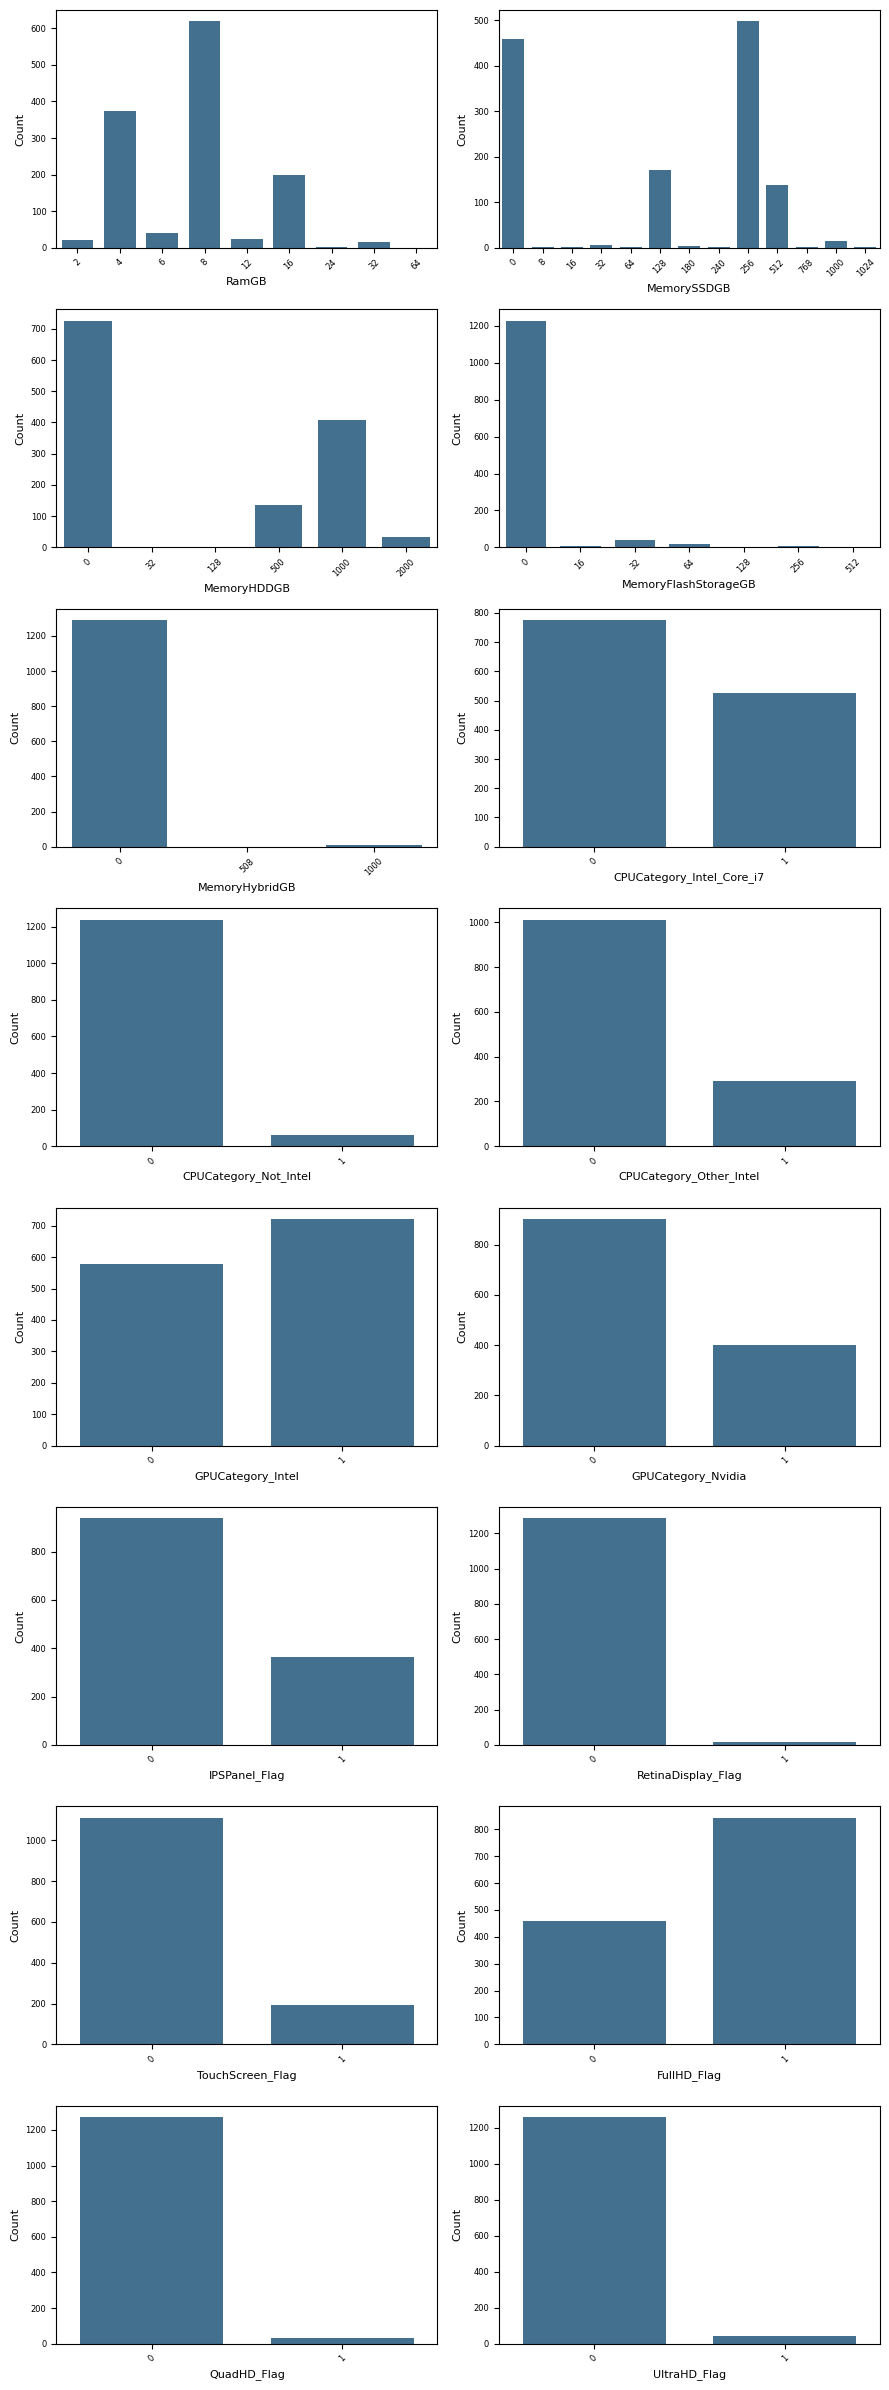

In [38]:
plot_categories(df, ['RamGB',
       'MemorySSDGB', 'MemoryHDDGB', 'MemoryFlashStorageGB', 'MemoryHybridGB',
       'CPUCategory_Intel_Core_i7', 'CPUCategory_Not_Intel', 'CPUCategory_Other_Intel', 'GPUCategory_Intel',
                    'GPUCategory_Nvidia', 'IPSPanel_Flag', 'RetinaDisplay_Flag', 'TouchScreen_Flag',
                    'FullHD_Flag', 'QuadHD_Flag', 'UltraHD_Flag'])

Remove outliers from the dataset based on the group frequencies of Memory-type features:

In [39]:
df = df.loc[df['RamGB'].isin([24, 64]) == False].copy()

df = df.loc[df['MemorySSDGB'].isin([0, 128, 256, 512])].copy()
df = df.loc[df['MemoryHDDGB'].isin([0, 500, 1000, 2000])].copy()
df = df.loc[df['MemoryFlashStorageGB'].isin([0, 32, 64])].copy()

df = df.loc[df['MemoryHybridGB'].isin([0])].copy()
df = df.loc[df['RetinaDisplay_Flag'].isin([0])].copy()

In [40]:
df.drop(['MemoryHybridGB', 'RetinaDisplay_Flag'], axis=1, inplace=True)
numerical_features.remove('MemoryHybridGB')
numerical_features.remove('RetinaDisplay_Flag')

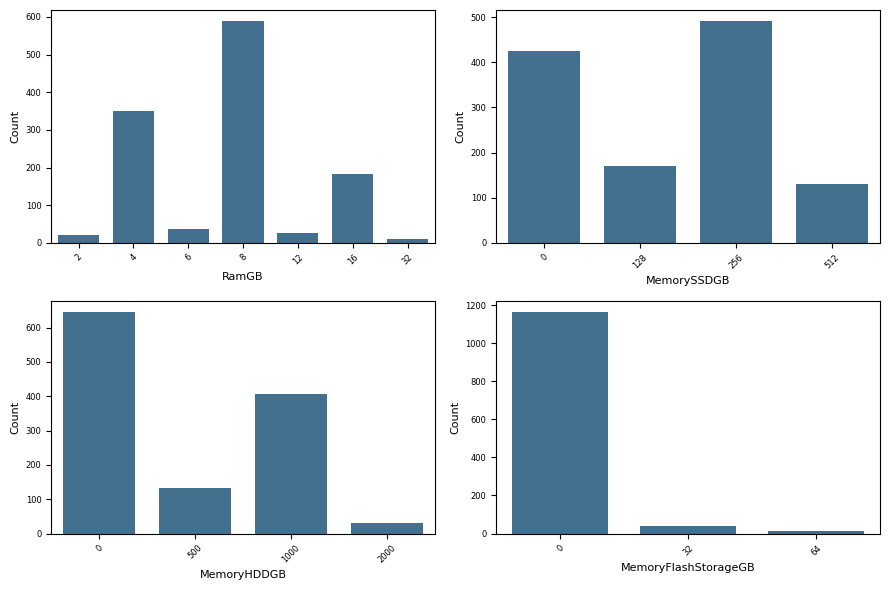

In [41]:
plot_categories(df, ['RamGB', 'MemorySSDGB', 'MemoryHDDGB', 'MemoryFlashStorageGB'])

In [42]:
df.shape

(1217, 26)

Plot histograms for numerical features:

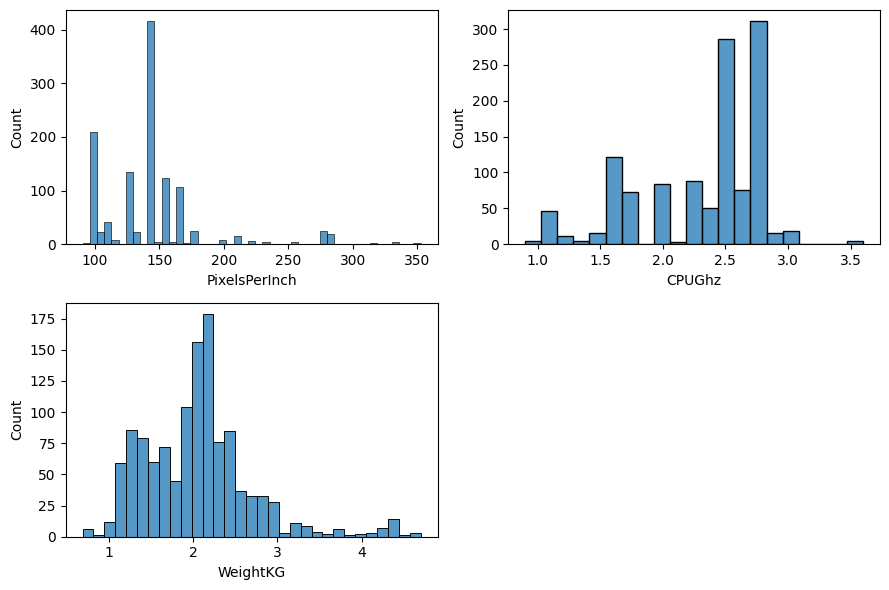

In [43]:
plot_histograms(df, ['PixelsPerInch', 'CPUGhz', 'WeightKG'])

## Train-test splitting

In [44]:
X = df[dummy_features+numerical_features]
y = df['Price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Number of observations in train sample: {X_train.shape[0]}')
print(f'Average log_price in train sample: {round(y_train.mean(),4)}')
print(f'Number of observations in test sample: {X_test.shape[0]}')
print(f'Average log_price in test sample: {round(y_test.mean(),4)}')

Number of observations in train sample: 851
Average log_price in train sample: 6.8417
Number of observations in test sample: 366
Average log_price in test sample: 6.8006


## Regression models

For model evaluation **R2-Score** will be used, which shows the goodness of fit of the regression model.

Cross validation for GridSearchCV:

In [45]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

### Linear regression

Check the correlation of features with the target to get sorted list of them

In [46]:
corr_with_target = pd.concat([X_train, y_train], axis=1).corr().abs().iloc[:,-1].sort_values(ascending=False)[1:]

Keep relevant features with higher than 0.2 in absolute value correlation coefficient with the target:

In [47]:
selected_features = corr_with_target.loc[corr_with_target >= 0.2].index.tolist()
selected_features

['RamGB',
 'MemorySSDGB',
 'CPUCategory_Other_Intel',
 'CPUCategory_Intel_Core_i7',
 'CPUGhz',
 'PixelsPerInch',
 'FullHD_Flag',
 'GPUCategory_Nvidia',
 'OpSysCategory_Windows',
 'OpSysCategory_Other',
 'MemoryFlashStorageGB',
 'IPSPanel_Flag',
 'UltraHD_Flag',
 'TouchScreen_Flag']

In [48]:
linreg = LinearRegression()
linreg.fit(X_train[selected_features], y_train);

Performance on train and test sample:

In [49]:
r2_score(y_train, linreg.predict(X_train[selected_features]))

0.7480455887992115

In [50]:
r2_score(y_test, linreg.predict(X_test[selected_features]))

0.7653650416085517

### Decision Tree Regressor

In [51]:
params_dtree = {'max_depth': [2,3,4,5,6]}
grid_dtree = GridSearchCV(DecisionTreeRegressor(min_samples_leaf=0.05),
                          params_dtree, cv=cv, scoring='r2', n_jobs=-1)

grid_dtree.fit(X_train[numerical_features+dummy_features], y_train)
grid_dtree.best_params_

{'max_depth': 6}

Performance on train sample using cross validation (average test results):

In [52]:
results = evaluate_cv(grid_dtree.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

R2 Score                   0.76410
Root Mean Squared Error    0.28318
dtype: float64

Performance on test sample:

In [53]:
r2_score(y_test, grid_dtree.best_estimator_.predict(X_test[numerical_features+dummy_features]))

0.7422318416979836

### Random Forest Regressor

In [54]:
params_rf = {'n_estimators': [75, 100, 125], 'max_depth': [3,4,5], 'max_features': [5]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=0),
                          params_rf, cv=cv, scoring='r2', n_jobs=-1)

grid_rf.fit(X_train[numerical_features+dummy_features], y_train)
grid_rf.best_params_

{'max_depth': 5, 'max_features': 5, 'n_estimators': 100}

Performance on train sample using cross validation (average test results):

In [55]:
results = evaluate_cv(grid_rf.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

R2 Score                   0.86098
Root Mean Squared Error    0.21880
dtype: float64

Performance on test sample:

In [56]:
r2_score(y_test, grid_rf.best_estimator_.predict(X_test[numerical_features+dummy_features]))

0.8311624257973663

### XGBoost Regressor

In [57]:
params_xgb = {'n_estimators': [50, 75, 100], 'max_depth': [2], 'learning_rate': [0.025, 0.05, 0.075, 0.1]}
grid_xgb = GridSearchCV(XGBRegressor(),
                          params_xgb, cv=cv, scoring='r2', n_jobs=-1)

grid_xgb.fit(X_train[numerical_features+dummy_features], y_train)
grid_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

Performance on train sample using cross validation (average test results):

In [58]:
results = evaluate_cv(grid_xgb.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

R2 Score                   0.88954
Root Mean Squared Error    0.19524
dtype: float64

Performance on test sample:

In [59]:
r2_score(y_test, grid_xgb.best_estimator_.predict(X_test[numerical_features+dummy_features]))

0.8606300819267996

## Summary

In [60]:
models_dict = {'Linear Regression': [r2_score(y_test, linreg.predict(X_test[selected_features])).round(4)],
               'Decision Tree': [r2_score(y_test, grid_dtree.best_estimator_.predict(X_test[numerical_features+dummy_features])).round(4)],
               'Random Forest': [r2_score(y_test, grid_rf.best_estimator_.predict(X_test[numerical_features+dummy_features])).round(4)],
               'XGBoost': [r2_score(y_test, grid_xgb.best_estimator_.predict(X_test[numerical_features+dummy_features])).round(4)]}

In [61]:
pd.DataFrame.from_dict(models_dict).T.rename(columns={0: 'R2-Score'}).sort_values(by='R2-Score', ascending=False)

,R2-Score
XGBoost,0.8606
Random Forest,0.8312
Linear Regression,0.7654
Decision Tree,0.7422


Based on the R2-Score evaluation metric the **XGBoost** model is the best regression model for predicting the laptop prices.

Notebook running time:

In [62]:
print(f'{round((time.time() - start_time)/60,4)} minutes.')

0.1467 minutes.
